# Is the Ideology Gap Growing?

[This tweet](https://twitter.com/jburnmurdoch/status/1750849189834022932) from John Burn-Murdoch links to an article in the Financial Times, ["A new global gender divide is emerging"](https://www.ft.com/content/29fd9b5c-2f35-41bf-9d4c-994db4e12998), which includes this figure:

![](https://github.com/AllenDowney/ProbablyOverthinkingIt/blob/book/data/ft_ideology_gap.png?raw=true)

The article claims:

> In the US, Gallup data shows that after decades where the sexes were each spread roughly equally across liberal and conservative world views, women aged 18 to 30 are now 30 percentage points more liberal than their male contemporaries. That gap took just six years to open up.

The figure says it is based on General Social Survey data and the text says it's based on Gallup data, so I'm not sure which it is.

And I don't know what it means that "All figures are adjusted for time trend in the overall population".

Anyway, since I used GSS data in the last three chapters of [*Probably Overthinking It*](https://greenteapress.com/wp/probably-overthinking-it/), this analysis did not sound right to me.

This notebook is my attempt to replicate the analysis with GSS data.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/ideology_gap.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def make_lowess(series, frac=0.4):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x, frac=frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [3]:
def plot_series_lowess(series, color, plot_series=True, frac=0.4, **options):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    if "label" not in options:
        options["label"] = series.name

    if plot_series or len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.3, label="_")

    if not plot_series and len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.6, label=options["label"])

    if len(series) > 1:
        smooth = make_lowess(series, frac=frac)
        smooth.plot(color=color, **options)

In [4]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

## Read the Data

I'm using data I previous cleaned for the [Political Alignment Case Study](https://allendowney.github.io/PoliticalAlignmentCaseStudy/)

In [5]:
from os.path import basename, exists
from pathlib import Path


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

In [6]:
download("https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_pacs_clean.hdf")

'gss_pacs_clean.hdf'

In [7]:
gss = pd.read_hdf('gss_pacs_clean.hdf', 'gss')
gss.shape

(72390, 204)

This version of the data is not corrected for stratified sampling, but that should not make much difference.

The primary variable we'll use is [polviews](https://subsetdataexplorer.norc.org/variables/178/vshow), which asks

> We hear a lot of talk these days about liberals and conservatives. I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

The points on the scale are Extremely liberal, Liberal, and Slightly liberal; Moderate;	Slightly conservative, Conservative, and Extremely conservative.

To confirm that my cleaning did not introduce errors, I compared the following cross-tabulation with the one in the [GSS Explorer](https://subsetdataexplorer.norc.org/variables/178/vshow).

In [8]:
year = gss["year"]
column = gss["polviews"]
xtab = pd.crosstab(column, year)
xtab

year,1974,1975,1976,1977,1978,1980,1982,1983,1984,1985,...,2004,2006,2008,2010,2012,2014,2016,2018,2021,2022
polviews,,,,,,,,,,,,,,,,,,,,,
1.0,22,46,31,37,22,36,48,16,29,35,...,46,139,69,76,81,94,136,122,207,192
2.0,201,179,187,169,142,121,199,67,133,163,...,120,524,240,259,244,304,350,278,623,486
3.0,207,196,186,214,241,208,267,98,177,171,...,153,517,221,232,208,263,310,256,490,400
4.0,564,559,559,564,549,582,694,319,568,566,...,497,1683,740,746,713,989,1032,855,1377,1245
5.0,221,232,221,251,263,258,235,142,276,271,...,214,618,268,265,268,334,382,283,476,430
6.0,160,150,190,179,188,180,229,108,186,214,...,223,685,327,315,292,358,426,354,617,514
7.0,35,35,27,39,30,44,67,20,41,42,...,56,167,68,80,68,107,120,99,174,159


I'll lump the first three points into "Liberal" and the last three into "Conservative".

In [9]:
recode_polviews = {
    1: "Liberal",
    2: "Liberal",
    3: "Liberal",
    4: "Moderate",
    5: "Conservative",
    6: "Conservative",
    7: "Conservative",
}

In [10]:
gss["polviews3"] = gss["polviews"].replace(recode_polviews)
gss["polviews3"].value_counts()

polviews3
Moderate        23992
Conservative    21122
Liberal         17604
Name: count, dtype: int64

The following functions generate a figure like the one in the FT.

In [11]:
def make_diff(df):
    """Compute % liberal minus % conservative.
    """
    year = df["year"]
    column = df["polviews3"]

    xtab = pd.crosstab(year, column, normalize='index')
    diff = xtab['Liberal'] - xtab['Conservative']
    
    return diff * 100

In [17]:
def make_plot(df, title=''):
    """Plot % liberal - % conservative for male and female respondents.
    """
    male = df.query('sex==1')
    female = df.query('sex==2')

    diff_male = make_diff(male)
    diff_female = make_diff(female)

    plot_series_lowess(diff_male, color='C0', label='Male')
    plot_series_lowess(diff_female, color='C1', label='Female')
    
    plt.xlabel('Year')
    plt.ylabel('% liberal - % conservative')
    plt.legend()
    plt.title(title)

Generate the plot for all respondents.

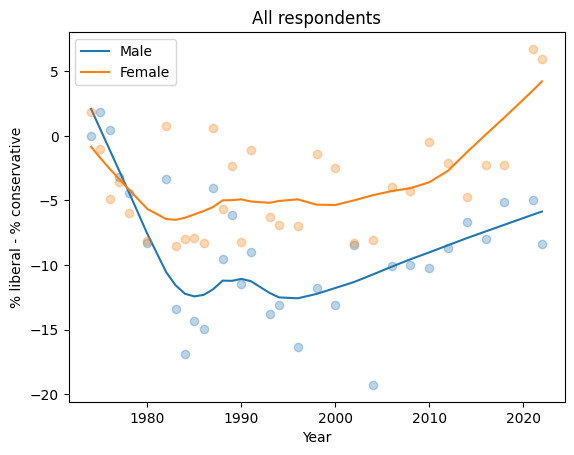

In [18]:
make_plot(gss, 'All respondents')

In the general population, men are more likely to say they are conservative, by 5-10 percentage points. 

The gap might have increased in the most recent data, depending on how seriously we take the last two points in a noisy series.

## Just young people

Now let's select just people under 30.

In [19]:
subset = gss.query('age < 30')
subset.shape

(14360, 205)

And make the same figure.

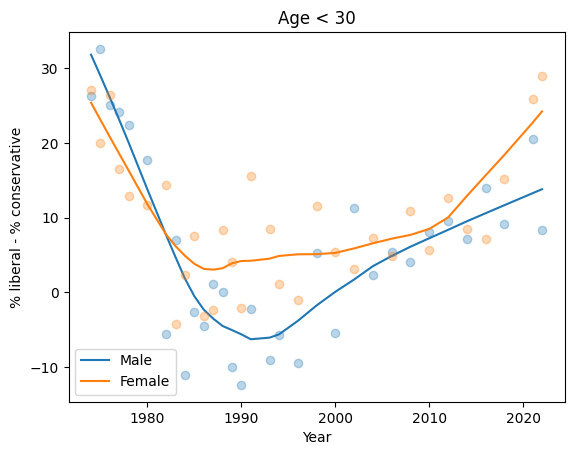

In [20]:
make_plot(subset, 'Age < 30')

The trends here are pretty much the same as in the general population.
Men are more likely to say they are conservative, by 5-10 percentage points.

It's possible that the gap has grown in the most recent data, but the evidence is weak and depends on how we draw a smooth curve through noisy data.

Anyway, there is no evidence the trend for men is going down, and the gap in the most recent data is nowhere near 30 percentage points.